# Diagnóstico de Falhas usando Redes Bayesianas - Versão 7 (Loopy Belief Propagation)

Este notebook implementa diagnóstico de falhas usando **Loopy Belief Propagation (LBP)**, um algoritmo iterativo de inferência aproximada.

**Características principais:**
- **Complexidade**: O(N × M × I) onde N=FMs, M=Clusters, I=iterações (~10-50)
- **Memória**: O(N + M) - muito menor que enumeração exaustiva (2^N)
- **Escalabilidade**: Funciona com qualquer número de FMs (sem limite prático)
- **Precisão**: Boa aproximação para redes com poucos ciclos

**Vantagens sobre v4 e v6:**
- Escala para qualquer número de FMs sem problemas de memória
- Complexidade linear em vez de exponencial
- Convergência rápida (geralmente <50 iterações)
- Ideal para casos com muitos FMs (>30)

**Quando usar:**
- Casos com muitos FMs (>30)
- Quando precisar de escalabilidade máxima
- Quando a precisão exata não é crítica (aproximação é suficiente)

## Importar Bibliotecas

In [1]:
import numpy as np
import math
from enum import Enum
import pandas as pd 
import itertools
from tqdm import tqdm


## Modelo Bayesiano com Loopy Belief Propagation

Implementação do algoritmo **Loopy Belief Propagation (LBP)** para inferência aproximada:

**Como funciona:**
1. **Mensagens FM → Cluster**: Cada FM envia mensagens sobre seu estado para clusters conectados
2. **Mensagens Cluster → FM**: Cada cluster envia mensagens sobre evidência observada para FMs conectados
3. **Iteração**: Processo iterativo até convergência (mudança < tolerância)
4. **Damping**: Fator de amortecimento (0.5) para estabilizar convergência
5. **Marginalização final**: Calcula probabilidades posteriores de cada FM

**Parâmetros:**
- `max_iter`: Máximo de iterações (padrão: 50)
- `tolerance`: Tolerância de convergência (padrão: 1e-6)
- `damping`: Fator de amortecimento 0-1 (padrão: 0.5, maior = mais estável mas mais lento)
- `p_true`: P(cluster=1 | qualquer FM ativo) = 0.99
- `p_false`: P(cluster=1 | nenhum FM ativo) = 0.01

**Complexidade**: O(N × M × I) onde I é o número de iterações até convergência.


In [2]:
class BayesianModel:
    def __init__(self, NumofFM, RS, CPT, CEvidence, FMProb, ProbFMTrueClusterTrue=None, ProbFMFalseClusterT=None):
        self.NumofFM = NumofFM
        self.RS = np.array(RS, dtype=int)
        self.CPT = [np.array(cpt, dtype=float) for cpt in CPT] if CPT is not None else None
        self.CEvidence = np.array(CEvidence, dtype=float)  # NaN = evidência ausente
        self.FMProb = np.array(FMProb, dtype=float)
        self.ProbFMTrueClusterTrue = ProbFMTrueClusterTrue
        self.ProbFMFalseClusterT = ProbFMFalseClusterT

class BayesianResult:
    def __init__(self, result=None):
        self.result = result

class BayesianType(Enum):
    ProbabilityFixed = 1
    ProbabilityCPT = 2
    ProbabilityLBP = 3

class Bayesian:
    @staticmethod
    def GetFMPostProbabilityLBP(model, max_iter=50, tolerance=1e-6, damping=0.5, p_true=0.99, p_false=0.01):
        """
        Loopy Belief Propagation for approximate inference.
        
        Args:
            model: BayesianModel instance
            max_iter: Maximum number of iterations (default: 50)
            tolerance: Convergence tolerance (default: 1e-6)
            damping: Damping factor for message updates (0-1, default: 0.5)
            p_true: P(cluster=1 | any FM active)
            p_false: P(cluster=1 | no FM active)
        
        Returns:
            Posterior probabilities for each FM: array of shape (num_fm,)
        """
        num_fm = model.NumofFM
        num_clusters = model.RS.shape[0]
        RS = model.RS  # (num_clusters, num_fm)
        evidence = model.CEvidence  # (num_clusters,)
        prior_fm = model.FMProb  # (num_fm,)
        
        EPSILON = 1e-15
        
        # Initialize messages:
        # msg_fm_to_cluster[i, j]: message from FM i to Cluster j (2 values: [P(FM=0), P(FM=1)])
        # msg_cluster_to_fm[j, i]: message from Cluster j to FM i (2 values: [P(FM=0), P(FM=1)])
        
        # Messages from FMs to Clusters (initialized to uniform)
        msg_fm_to_cluster = np.ones((num_fm, num_clusters, 2), dtype=float) * 0.5
        
        # Messages from Clusters to FMs (initialized to uniform)
        msg_cluster_to_fm = np.ones((num_clusters, num_fm, 2), dtype=float) * 0.5
        
        # Previous messages for damping
        prev_msg_fm_to_cluster = msg_fm_to_cluster.copy()
        prev_msg_cluster_to_fm = msg_cluster_to_fm.copy()
        
        for iteration in range(max_iter):
            # ============================================
            # Update messages from Clusters to FMs
            # ============================================
            for c in range(num_clusters):
                # Get FMs connected to this cluster
                connected_fms = np.where(RS[c, :] == 1)[0]
                
                if len(connected_fms) == 0:
                    continue
                
                # Evidence for this cluster (NaN = sem evidência: não entra na inferência)
                e_c = evidence[c]
                if np.isnan(e_c):
                    continue
                
                # For each FM connected to this cluster
                for fm_idx in connected_fms:
                    # Get other FMs (excluding current FM)
                    other_fms = connected_fms[connected_fms != fm_idx]
                    
                    # Compute message from cluster to FM
                    # We need to marginalize over other FMs
                    
                    if len(other_fms) == 0:
                        # Single FM case: simple likelihood
                        # P(cluster=e_c | FM=0) and P(cluster=e_c | FM=1)
                        prob_fm0 = p_false if e_c == 1 else (1.0 - p_false)
                        prob_fm1 = p_true if e_c == 1 else (1.0 - p_true)
                        
                        msg_cluster_to_fm[c, fm_idx, 0] = prob_fm0
                        msg_cluster_to_fm[c, fm_idx, 1] = prob_fm1
                    else:
                        # Multiple FMs: need to marginalize
                        # P(cluster=e_c | FM_i, other_FMs)
                        
                        # Compute for FM=0 and FM=1
                        prob_fm0 = 0.0
                        prob_fm1 = 0.0
                        
                        # Enumerate over other FMs (only if few, otherwise approximate)
                        num_other = len(other_fms)
                        if num_other <= 10:  # Exact enumeration for small number
                            for other_state in itertools.product([0, 1], repeat=num_other):
                                # Compute probability of this state
                                state_prob = 1.0
                                for i, other_fm in enumerate(other_fms):
                                    fm_state = other_state[i]
                                    # Use incoming message from FM to cluster
                                    msg_val = msg_fm_to_cluster[other_fm, c, fm_state]
                                    state_prob *= msg_val
                                
                                # For FM=0: check if any other FM is active
                                any_active = any(s == 1 for s in other_state)
                                
                                # Likelihood given this state (FM=0)
                                if any_active:
                                    like = p_true if e_c == 1 else (1.0 - p_true)
                                else:
                                    like = p_false if e_c == 1 else (1.0 - p_false)
                                
                                prob_fm0 += state_prob * like
                                
                                # For FM=1: always active (any_active = True)
                                like = p_true if e_c == 1 else (1.0 - p_true)
                                prob_fm1 += state_prob * like
                        else:
                            # Approximation: assume independence
                            # P(any other FM active) ≈ 1 - product(1 - P(other_FM))
                            prob_other_active = 1.0
                            for other_fm in other_fms:
                                prob_other_active *= (1.0 - msg_fm_to_cluster[other_fm, c, 1])
                            prob_other_active = 1.0 - prob_other_active
                            
                            # FM=0: only other FMs can activate
                            prob_activate = prob_other_active
                            prob_fm0 = (p_true if e_c == 1 else (1.0 - p_true)) * prob_activate + \
                                      (p_false if e_c == 1 else (1.0 - p_false)) * (1.0 - prob_activate)
                            
                            # FM=1: always activates
                            prob_fm1 = p_true if e_c == 1 else (1.0 - p_true)
                        
                        # Normalize
                        msg_sum = prob_fm0 + prob_fm1
                        if msg_sum > EPSILON:
                            msg_cluster_to_fm[c, fm_idx, 0] = prob_fm0 / msg_sum
                            msg_cluster_to_fm[c, fm_idx, 1] = prob_fm1 / msg_sum
                        else:
                            msg_cluster_to_fm[c, fm_idx, :] = 0.5
            
            # ============================================
            # Update messages from FMs to Clusters
            # ============================================
            for fm_idx in range(num_fm):
                # Get clusters connected to this FM
                connected_clusters = np.where(RS[:, fm_idx] == 1)[0]
                
                if len(connected_clusters) == 0:
                    continue
                
                # Prior for this FM
                prior_0 = 1.0 - prior_fm[fm_idx]
                prior_1 = prior_fm[fm_idx]
                
                # For each cluster connected to this FM
                for c in connected_clusters:
                    # Get other clusters (excluding current)
                    other_clusters = connected_clusters[connected_clusters != c]
                    
                    # Compute message from FM to cluster
                    # Product of prior and messages from other clusters
                    
                    msg_0 = prior_0
                    msg_1 = prior_1
                    
                    for other_c in other_clusters:
                        msg_0 *= msg_cluster_to_fm[other_c, fm_idx, 0]
                        msg_1 *= msg_cluster_to_fm[other_c, fm_idx, 1]
                    
                    # Normalize
                    msg_sum = msg_0 + msg_1
                    if msg_sum > EPSILON:
                        msg_fm_to_cluster[fm_idx, c, 0] = msg_0 / msg_sum
                        msg_fm_to_cluster[fm_idx, c, 1] = msg_1 / msg_sum
                    else:
                        msg_fm_to_cluster[fm_idx, c, :] = 0.5
            
            # Apply damping
            msg_fm_to_cluster = damping * prev_msg_fm_to_cluster + (1.0 - damping) * msg_fm_to_cluster
            msg_cluster_to_fm = damping * prev_msg_cluster_to_fm + (1.0 - damping) * msg_cluster_to_fm
            
            # Check convergence
            diff_fm = np.max(np.abs(msg_fm_to_cluster - prev_msg_fm_to_cluster))
            diff_cluster = np.max(np.abs(msg_cluster_to_fm - prev_msg_cluster_to_fm))
            
            if max(diff_fm, diff_cluster) < tolerance:
                break
            
            prev_msg_fm_to_cluster = msg_fm_to_cluster.copy()
            prev_msg_cluster_to_fm = msg_cluster_to_fm.copy()
        
        # ============================================
        # Compute final marginals for FMs
        # ============================================
        posterior_probs = np.zeros(num_fm, dtype=float)
        
        for fm_idx in range(num_fm):
            connected_clusters = np.where(RS[:, fm_idx] == 1)[0]
            
            # Combine prior with all cluster messages
            prior_0 = 1.0 - prior_fm[fm_idx]
            prior_1 = prior_fm[fm_idx]
            
            marginal_0 = prior_0
            marginal_1 = prior_1
            
            for c in connected_clusters:
                marginal_0 *= msg_cluster_to_fm[c, fm_idx, 0]
                marginal_1 *= msg_cluster_to_fm[c, fm_idx, 1]
            
            # Normalize
            marginal_sum = marginal_0 + marginal_1
            if marginal_sum > EPSILON:
                posterior_probs[fm_idx] = marginal_1 / marginal_sum
            else:
                posterior_probs[fm_idx] = prior_fm[fm_idx]
        
        return posterior_probs


## Carregar Dados de Clusters

Carrega os dados de evidência dos clusters (valores observados True/False para cada cluster em cada amostra).

**Nota**: A primeira coluna pode ser ignorada se necessário (código comentado no v6).


In [3]:
df_evidance = pd.read_csv("dados/Cluster_data_Nan.csv")
df_evidance

,Cluster1,Cluster2,Cluster3
0,False,NaN,NaN
1,False,NaN,NaN
2,False,NaN,NaN
3,False,NaN,NaN
4,False,NaN,NaN
...,...,...,...
75,False,False,False
76,False,False,False
77,False,False,False
78,False,False,False


## Carregar Dados de Failure Modes (FMs) e Construir Matriz RS

Carrega o mapeamento dos FMs e suas conexões com os clusters, depois constrói a matriz de relação RS.

A matriz RS define as dependências entre Clusters (linhas) e Failure Modes (colunas):
- **RS[i, j] = 1**: O Cluster i depende do FM j
- **RS[i, j] = 0**: Não há dependência

**Otimização**: Mantida como array NumPy para melhor performance.


## Construir Matriz de Relação RS

Código para construir a matriz RS a partir dos dados de mapeamento de FMs.

In [4]:
df = pd.read_csv("dados/FM_mapping.csv")

In [5]:


# --- 1. Define Columns (FMs) and Rows (Clusters) ---

# Get the list of Factor Machines (FMs) for matrix columns (FMA, FMB, ...)
fm_list = df['FM'].tolist()
NUM_FM = len(fm_list)

# Split the 'Connected_Clusters' string by ';' and collect all unique cluster names
all_clusters = df['Connected_Clusters'].str.split(';').explode().unique()

# Sort clusters numerically (Cluster1, Cluster2, ..., Cluster37)
cluster_list = sorted(all_clusters, key=lambda x: int(x.replace('Cluster', '')))
NUM_CLUSTERS = len(cluster_list)

# Create a mapping for quick index lookup
cluster_to_index = {cluster: i for i, cluster in enumerate(cluster_list)}
fm_to_index = {fm: i for i, fm in enumerate(fm_list)}

# --- 2. Initialize and Populate the RS_MATRIX ---

# Initialize the matrix with zeros (Rows=Clusters, Columns=FMs)
rs_matrix = np.zeros((NUM_CLUSTERS, NUM_FM), dtype=int)

# Iterate through the DataFrame rows (each row represents an FM's connection)
for _, row in df.iterrows():
    fm_name = row['FM']
    connected_clusters = row['Connected_Clusters'].split(';')
    
    # Get the column index for the current FM
    fm_col_index = fm_to_index[fm_name]
    
    # For every cluster connected to this FM, set the corresponding matrix cell to 1
    for cluster_name in connected_clusters:
        cluster_row_index = cluster_to_index[cluster_name]
        # Dependency is set: Cluster (Row) depends on FM (Column)
        rs_matrix[cluster_row_index, fm_col_index] = 1

# Keep as NumPy array
RS_MATRIX = rs_matrix

# --- 3. Output and Display ---

print(f"FM List (Columns): {len(fm_list)} FMs")
print(f"Cluster List (Rows): {len(cluster_list)} Clusters")
print(f"RS_MATRIX shape: {RS_MATRIX.shape}")


FM List (Columns): 3 FMs
Cluster List (Rows): 3 Clusters
RS_MATRIX shape: (3, 3)


In [6]:

#P_fail_by_t = 1.0 - df["Failure_Rate"].astype(float)



# Step 4: New prior failure probabilities (keep as NumPy array)
PRIOR_FM_PROB = df["Failure_Rate"].astype(float) # Already NumPy array

print(f"Computed prior probabilities for {len(PRIOR_FM_PROB)} FMs")
print(f"Prior prob range: [{PRIOR_FM_PROB.min():.6f}, {PRIOR_FM_PROB.max():.6f}]")


Computed prior probabilities for 3 FMs
Prior prob range: [0.080000, 0.120000]


## Executar Loop de Inferência LBP

Para cada amostra de evidência:
1. Constrói um modelo bayesiano com as evidências observadas
2. Executa Loopy Belief Propagation até convergência
3. Armazena as probabilidades posteriores de cada FM

**Otimizações:**
- Converte DataFrame de evidências para array NumPy uma vez
- Usa `tqdm` para barra de progresso
- Tratamento de erros robusto

**Resultados**: Cada amostra gera probabilidades para todos os FMs usando o método LBP (aproximação iterativa).

## Loopy Belief Propagation Inference Loop

**Vantagens do LBP:**
- **Complexidade**: O(N × M × I) onde I ≈ 10-50 iterações
- **Memória**: O(N + M) - muito menor que enumeração
- **Escalável**: Funciona com qualquer número de FMs
- **Precisão**: Boa aproximação para redes com poucos ciclos


In [7]:
# ----------------------------
# LBP Inference Loop
# ----------------------------
all_results = []

# LBP Parameters
MAX_ITER = 50  # Maximum iterations
TOLERANCE = 1e-6  # Convergence tolerance
DAMPING = 0.5  # Damping factor (0-1, higher = more stable but slower)
P_TRUE = 0.99  # P(cluster=1 | any FM active)
P_FALSE = 0.01  # P(cluster=1 | no FM active)

# Convert evidence DataFrame to NumPy array once (faster than iterating)
evidence_matrix = df_evidance.values.astype(float)  # preserva NaN (cluster ignorado no LBP)

print(f"Starting LBP inference for {len(df_evidance)} samples...")
print(f"Parameters: max_iter={MAX_ITER}, tolerance={TOLERANCE}, damping={DAMPING}")
print()

# Use tqdm for progress tracking
for idx in tqdm(range(len(df_evidance)), desc="Processing samples"):
    evidence_vector = evidence_matrix[idx]

    # Build model
    test_model = BayesianModel(
        NumofFM=NUM_FM,
        RS=RS_MATRIX,
        CPT=None,  # Not used in LBP method
        CEvidence=evidence_vector,
        FMProb=PRIOR_FM_PROB,
        ProbFMTrueClusterTrue=P_TRUE,
        ProbFMFalseClusterT=P_FALSE
    )

    try:
        # Use Loopy Belief Propagation
        fixed_result = Bayesian.GetFMPostProbabilityLBP(
            model=test_model,
            max_iter=MAX_ITER,
            tolerance=TOLERANCE,
            damping=DAMPING,
            p_true=P_TRUE,
            p_false=P_FALSE
        )
    except Exception as e:
        print(f"\n[ERROR] Failed at sample {idx}: {e}")
        import traceback
        traceback.print_exc()
        continue

    # Record output
    row = {"sample": idx}
    row.update({f"FM{i+1}_LBP": prob for i, prob in enumerate(fixed_result)})
    all_results.append(row)

print(f"\n✓ Completed processing {len(all_results)} samples")
print(f"  (Used Loopy Belief Propagation with max {MAX_ITER} iterations)")


Starting LBP inference for 80 samples...
Parameters: max_iter=50, tolerance=1e-06, damping=0.5



Processing samples: 100%|██████████| 80/80 [00:00<00:00, 1380.28it/s]


✓ Completed processing 80 samples
  (Used Loopy Belief Propagation with max 50 iterations)


## Convert and Save Results


In [8]:
# Convert results to DataFrame
df_results = pd.DataFrame(all_results)
print(f"Results shape: {df_results.shape}")
print(f"\nFirst few rows:")
print(df_results.head())

# Save results to CSV
import os
os.makedirs("outputs", exist_ok=True)
output_file = "outputs/fm_posteriors_per_sample_v7_lbp.csv"
df_results.to_csv(output_file, index=False)
print(f"\n✓ Results saved to {output_file}")


Results shape: (80, 4)

First few rows:
   sample   FM1_LBP  FM2_LBP  FM3_LBP
0       0  0.000878     0.12     0.12
1       1  0.000878     0.12     0.12
2       2  0.000878     0.12     0.12
3       3  0.000878     0.12     0.12
4       4  0.000878     0.12     0.12

✓ Results saved to outputs/fm_posteriors_per_sample_v7_lbp.csv


## Visualization


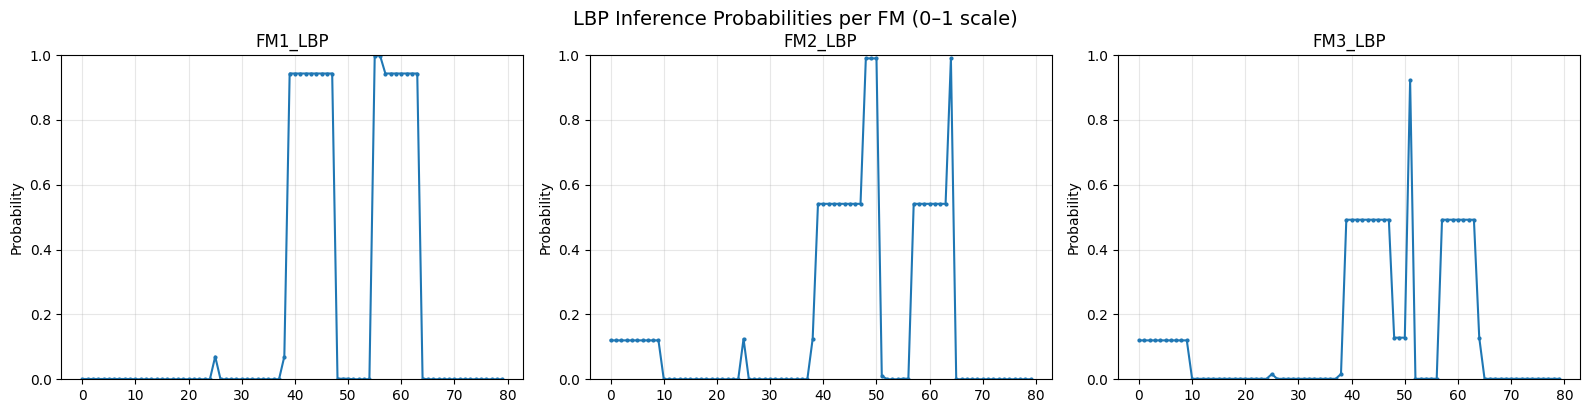

In [9]:
import matplotlib.pyplot as plt

# Plot each FM's LBP values across samples with fixed y-axis from 0 to 1
num_fms = len([c for c in df_results.columns if c.endswith("_LBP")])
num_cols = 3
num_rows = (num_fms + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows), sharex=True)
axs = axs.flatten() if num_rows > 1 else [axs] if num_cols == 1 else axs

fm_keys = [c for c in df_results.columns if c.endswith("_LBP")]
for i, fm_key in enumerate(fm_keys):
    if i < len(axs):
        axs[i].plot(df_results["sample"], df_results[fm_key], marker='o', markersize=2, label=fm_key)
        axs[i].set_ylim(0, 1)
        axs[i].set_title(fm_key)
        axs[i].set_ylabel("Probability")
        axs[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(len(fm_keys), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle("LBP Inference Probabilities per FM (0–1 scale)", fontsize=14, y=1.02)
plt.show()
